In [1]:
import pandas as pd
import matplotlib.pyplot as plt

# Reading and Cleaning
Todo
* save cleaned dataset

In [2]:
df = pd.read_csv('data/data_cleaned_clustered') #data/df_audio_features_1000')
df = (df
    .assign(song_artist = df['name'] + " by " + df['artist'] + "(" + df['id'] + ")")
    .drop(columns='type')
    .dropna()
    .drop_duplicates()
)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1434 entries, 0 to 1439
Data columns (total 18 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   name              1434 non-null   object 
 1   artist            1434 non-null   object 
 2   danceability      1434 non-null   float64
 3   energy            1434 non-null   float64
 4   key               1434 non-null   int64  
 5   loudness          1434 non-null   float64
 6   mode              1434 non-null   int64  
 7   speechiness       1434 non-null   float64
 8   acousticness      1434 non-null   float64
 9   instrumentalness  1434 non-null   float64
 10  liveness          1434 non-null   float64
 11  valence           1434 non-null   float64
 12  tempo             1434 non-null   float64
 13  duration_ms       1434 non-null   int64  
 14  time_signature    1434 non-null   int64  
 15  id                1434 non-null   object 
 16  html              1434 non-null   object 


# Pre-processing
Todo
* different scalers

In [3]:
from src.proj4_utils import test_num_data_scale

# min max values of features that are not within [0,1] according to
# https://developer.spotify.com/documentation/web-api/reference/#/operations/get-several-audio-features
from sys import maxsize as sys_maxsize
scale_dict = {'key' : (-1, 11), 
              'loudness' : (-60, 0), 
              'time_signature' : (3, 7), 
              'duration_ms' : (0, sys_maxsize), 
              'tempo' : (0, sys_maxsize),
              'default' : (0, 1)}

from src.utils import get_numerical_columns
df_num = df[get_numerical_columns(df)]
#test_num_data_scale(df_num, scale_dict)  #<<<<<------------test scaling

# set a priori knowledge min/max for proper fitting of the scaler
# instead of using at hand values that might not extend well to future data
df_num_minmax = df_num.describe().loc[['min', 'max'],:]
scale_dict.pop('default', None)
df_num_minmax.loc[:,scale_dict.keys()] = pd.DataFrame(
                                            data = scale_dict, 
                                            columns = scale_dict.keys(), 
                                            index = df_num_minmax.index)

from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0,1))
scaler.fit(df_num_minmax)

# apply the scaler
df_num_scaled = pd.DataFrame(scaler.transform(df_num), columns=df_num.columns, index=df_num.index)

In [4]:
df_num_scaled.describe()

danceability       energy          key     loudness         mode  \
count   1434.000000  1434.000000  1434.000000  1434.000000  1434.000000   
mean       0.529702     0.496230     0.513192     0.814870     0.662483   
std        0.242552     0.283048     0.295339     0.116463     0.473028   
min        0.000000     0.000000     0.083333     0.259900     0.000000   
25%        0.360902     0.244212     0.250000     0.750437     0.000000   
50%        0.555506     0.531617     0.500000     0.851008     1.000000   
75%        0.719980     0.735938     0.750000     0.905338     1.000000   
max        1.000000     1.000000     1.000000     1.018083     1.000000   

       speechiness  acousticness  instrumentalness     liveness      valence  \
count  1434.000000   1434.000000       1434.000000  1434.000000  1434.000000   
mean      0.113876      0.471413          0.192057     0.159561     0.469110   
std       0.155390      0.376077          0.342248     0.151639     0.298362   
min       0.000000      0.000000          0.000000     0.000000     0.000000   
25%       0.027496      0.083206          0.000000     0.072617     0.201626   
50%       0.045224      0.420681          0.000130     0.100902     0.473275   
75%       0.118804      0.872490          0.165228     0.189049     0.725502   
max       1.000000      1.000000          1.000000     1.000000     1.000000   

              tempo   duration_ms  time_signature  
count  1.434000e+03  1.434000e+03     1434.000000  
mean   1.248972e-17  3.162551e-14        0.222455  
std    3.426436e-18  2.476664e-14        0.111802  
min    5.387292e-18  6.804236e-15       -0.500000  
25%    9.866755e-18  2.094570e-14        0.250000  
50%    1.192091e-17  2.534735e-14        0.250000  
75%    1.469457e-17  3.348339e-14        0.250000  
max    2.236850e-17  4.137085e-13        0.500000

In [5]:
from sklearn.metrics import pairwise_distances

# metric = ['euclidean', 'manhatten']
def get_distances(df, metric = 'euclidean', labels = None):
    if labels is not None:
        df = df.copy().set_index(labels)
    return pd.DataFrame(pairwise_distances(df, metric = metric), index=df.index, columns=df.index)

# Euclidean (by default)
ecl_dis = get_distances(df_num_scaled, labels = df['song_artist'])

# K-Means

TODO
* automatic selection of number of clusters via inertia & silhouette score

In [6]:
from sklearn.cluster import KMeans

# from scatter plot we can see shit, 
# we are going to assume there can be num_clusters different clusters.
num_clusters = 7
kmeans = KMeans(n_clusters=num_clusters)
kmeans.fit(df_num_scaled)

KMeans(n_clusters=7)

In [7]:
cl_pos = pd.DataFrame(kmeans.cluster_centers_)
cl_pos.columns = df_num_scaled.columns
df_num_scaled['clusters'] = kmeans.labels_
df_num_scaled['id'] = df.loc[:,'id']

In [8]:
df_num_scaled.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 1434 entries, 0 to 1439
Data columns (total 15 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   danceability      1434 non-null   float64
 1   energy            1434 non-null   float64
 2   key               1434 non-null   float64
 3   loudness          1434 non-null   float64
 4   mode              1434 non-null   float64
 5   speechiness       1434 non-null   float64
 6   acousticness      1434 non-null   float64
 7   instrumentalness  1434 non-null   float64
 8   liveness          1434 non-null   float64
 9   valence           1434 non-null   float64
 10  tempo             1434 non-null   float64
 11  duration_ms       1434 non-null   float64
 12  time_signature    1434 non-null   float64
 13  clusters          1434 non-null   int32  
 14  id                1434 non-null   object 
dtypes: float64(13), int32(1), object(1)
memory usage: 173.6+ KB


# Visualising Results
Todo
* 

Text(0.5, 1.0, 'Looking for a relation between features')

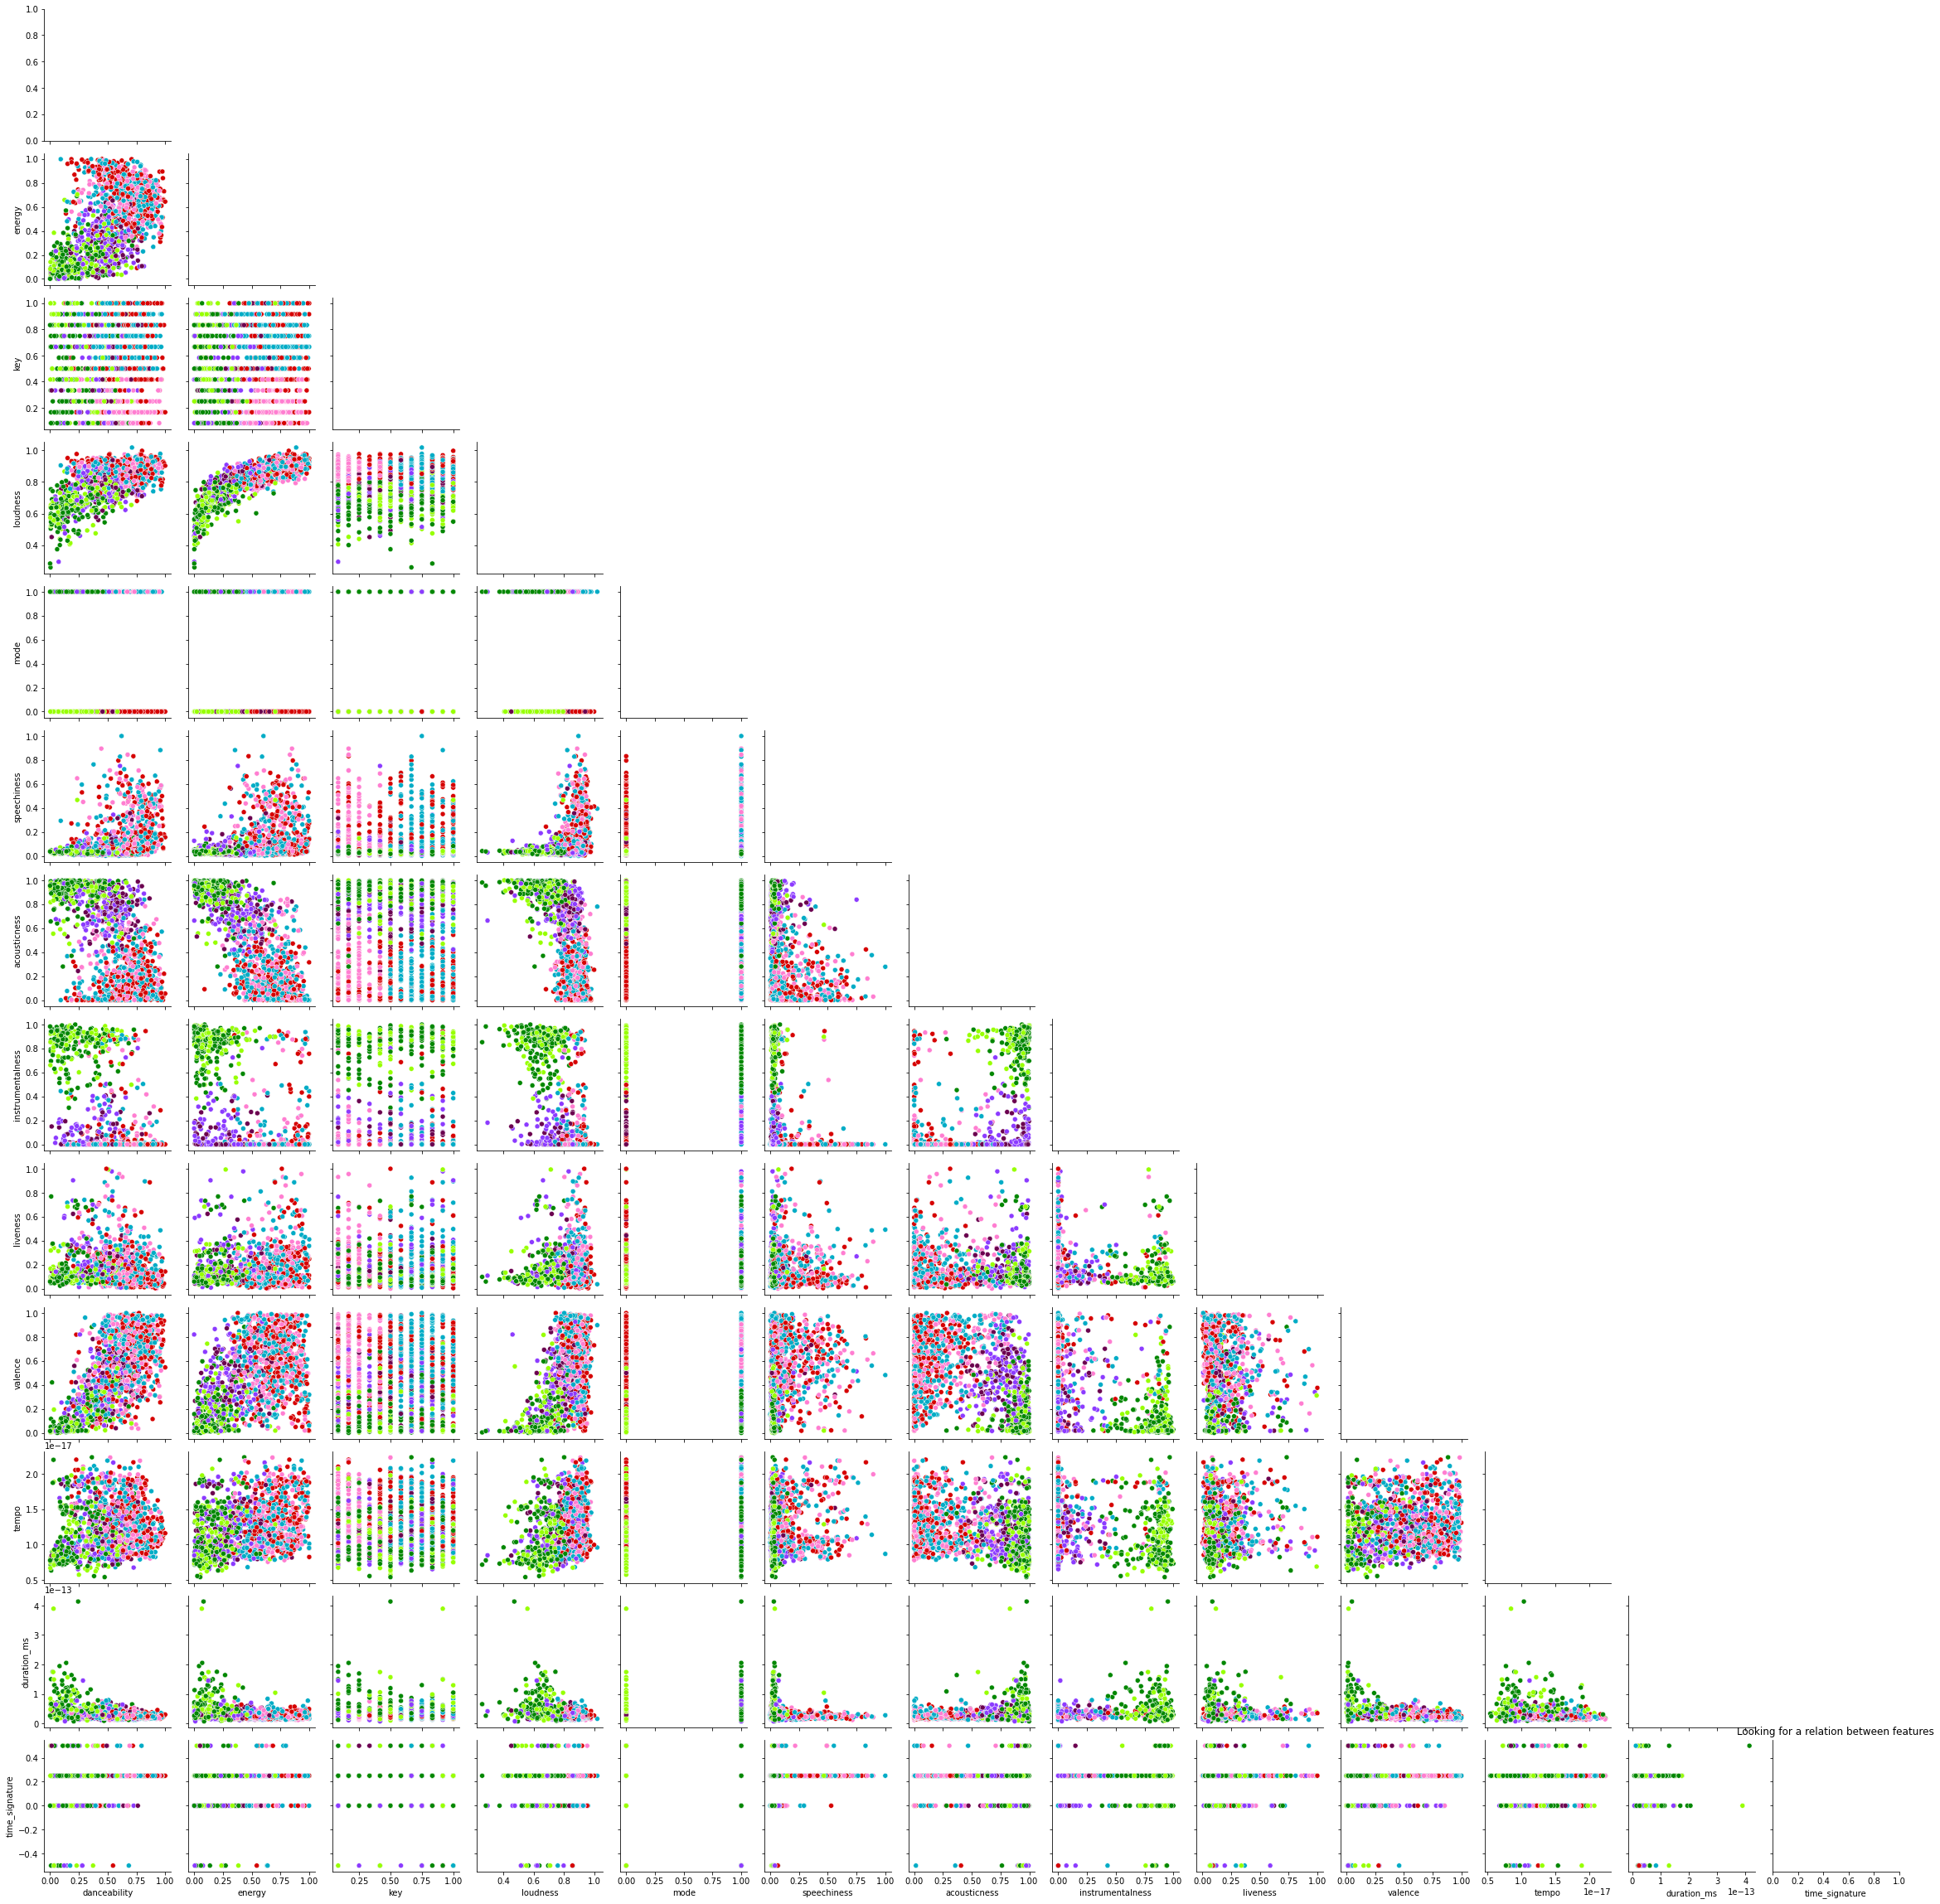

In [9]:
from src.utils import install_pip_pkg
install_pip_pkg({'colorcet'})
import colorcet as cc
import seaborn as sns

# retrospective pairwise scatterplots of all features with clusters as hue
palette = sns.color_palette(cc.glasbey, n_colors=num_clusters)
g = sns.PairGrid(df_num_scaled, hue='clusters', palette = palette, corner=True)
g.map_lower(sns.scatterplot)
plt.title('Looking for a relation between features')

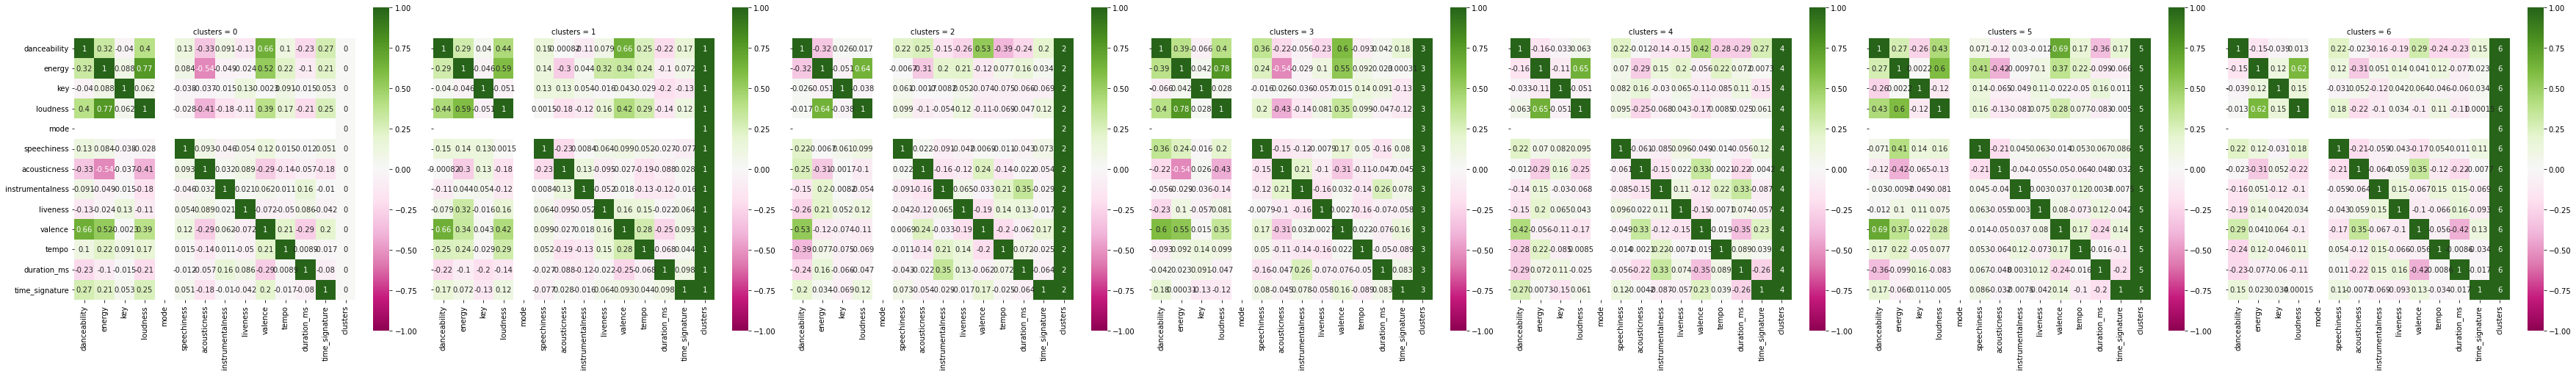

In [13]:
from src.visualisations import corr_heatmap
df_corr_data = corr_heatmap(df_num_scaled)

In [24]:
for i in range(num_clusters + 1):
    print(df_corr_data.loc[df_corr_data['clusters'] == i, ['clusters', 'sum']].sort_values(by='sum', ascending=False))

                  clusters       sum
valence                  0  2.511093
energy                   0  2.496820
danceability             0  2.246958
loudness                 0  2.092451
time_signature           0  1.723836
tempo                    0  1.608888
speechiness              0  1.423562
key                      0  1.274456
instrumentalness         0  1.074830
liveness                 0  0.943725
duration_ms              0  0.254868
mode                     0  0.000000
acousticness             0 -0.767905
                  clusters       sum
valence                  1  2.835547
danceability             1  2.748735
energy                   1  2.582817
loudness                 1  2.531407
tempo                    1  1.896560
liveness                 1  1.805893
time_signature           1  1.456599
speechiness              1  1.318237
key                      1  0.927430
instrumentalness         1  0.707942
acousticness             1  0.183917
mode                     1  0.000000
d

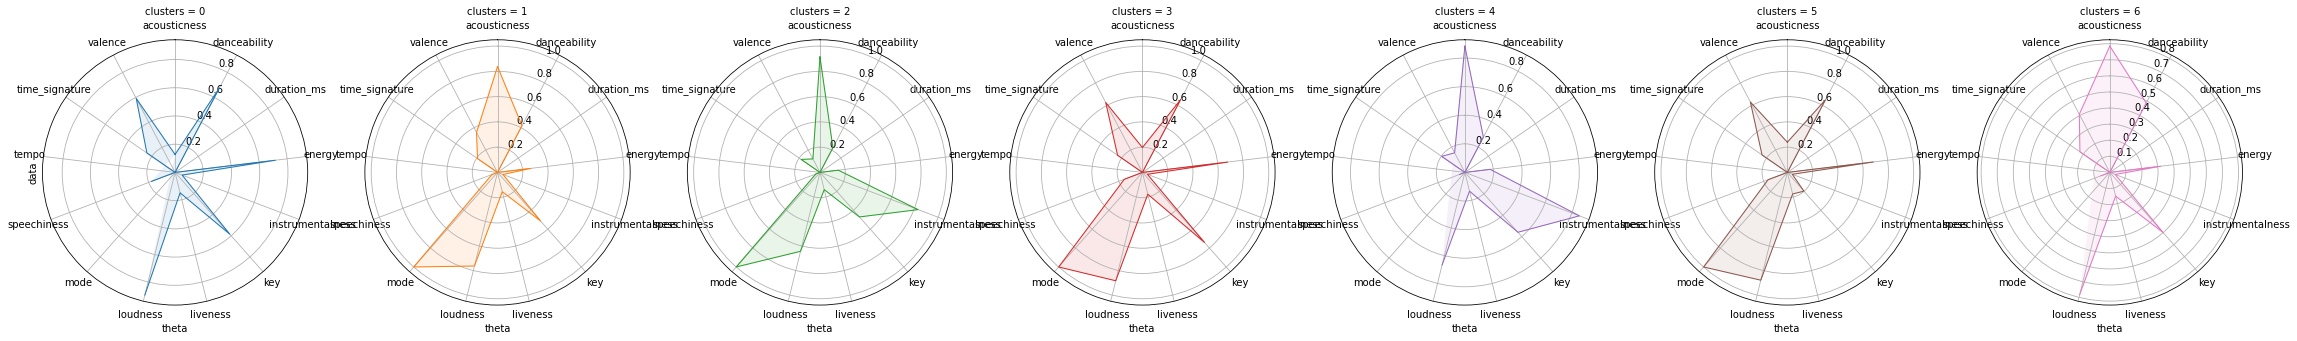

In [101]:
from src.visualisations import spider_plot
spider_plot(cl_pos)

# Metrics
Todo
* get genre from Spotify API
* compare to myJam dataset
* get playlists from Spotify API and count in-cluster-songs occurences


In [31]:
class SpotifyHandler():
    def __init__(self, env_file_path):
        self.__sp = self.setup_spotify_connection(env_file_path)
        
    def setup_spotify_connection(self, env_file_path):
        from src.utils import install_pip_pkg
        install_pip_pkg({'spotipy'})

        # import libraries
        import spotipy
        from spotipy.oauth2 import SpotifyClientCredentials
        from src.utils import ConfigHandler

        #Initialize SpotiPy with user credentias
        config_handler = ConfigHandler(env_file_path)
        client_keys = config_handler.load_config('spotify')
        sp = spotipy.Spotify(client_credentials_manager=SpotifyClientCredentials(
            client_id = client_keys['client_id'], client_secret = client_keys['client_secret']))
        return sp
    
    def get_connection():
        return self.__sp
    
    def retrieve_tracks(self, cluster_song_id_list):   
        # regarding ids : a list of spotify URIs, URLs or IDs. Maximum: 50 IDs.
        # install flatdict
        from src.utils import install_pip_pkg
        install_pip_pkg({'flatdict'})
        from flatdict import FlatterDict as flatten
        from pandas import json_normalize as pd_json_normalize
        song_list = self.retrieve_bits_for_tracks(cluster_song_id_list, self.__sp.tracks, market=None)
        df_songs = pd_json_normalize([dict(flatten(i)) for i in song_list[0]['tracks']])
        return df_songs
    
    def retrieve_artists_from_songs(self, cluster_song_id_list, return_all = 'no'):  
        # regarding ids : a list of spotify URIs, URLs or IDs. Maximum: 50 IDs.
        df_songs = self.retrieve_tracks(cluster_song_id_list)
        srs_artist_ids = df_songs['album:artists:0:id']
        df_artists = pd.json_normalize(self.__sp.artists(srs_artist_ids)['artists'])
        
        if return_all == 'no':
            return df_artists
        else:
            return df_songs, df_artists
    
    def retrieve_genre_from_songs(self, cluster_song_id_list, return_all = 'no'):
        df_songs, df_artists = self.retrieve_artists_from_songs(cluster_song_id_list, return_all = 'yes')
        df_songs['artist_genres'] = df_artists[['genres']]
        
        if return_all == 'no':
            return df_songs
        else:
            return df_songs, df_artists
        
    def retrieve_bits_for_tracks(self, cluster_song_id_list, func, **kwargs):        
        # retrieving tracks
        # regarding ids : a list of spotify URIs, URLs or IDs. Maximum: 50 IDs.
        song_list = []
        id_list_len = len(cluster_song_id_list)
        step = 50
        for lower in list(range(0, id_list_len, step)) + [id_list_len % step]:
            upper = min(id_list_len - lower, 50)
            song_list.append(func(cluster_song_id_list[lower:upper], **kwargs))
        return song_list
        
def metric_compare_genre(sp_handler, cluster_song_id_list):
    return sp_handler.retrieve_genre_from_songs(cluster_song_id_list)

sp_handler = SpotifyHandler('.env_spotify')

df_num_scaled = pd.read_csv('data/data_cleaned_clustered.csv') #data/df_audio_features_1000')

df_song_list = []
for i in range(num_clusters + 1):
    mask = df_num_scaled['cluster'] == i
    df_song_list.append(metric_compare_genre(sp_handler, df_num_scaled.loc[mask,'id'].head(50)))

Max Retries reached


SpotifyException: http status: 429, code:-1 - /v1/tracks/?ids=3ftxaxht5yQW99vNcibmUC%20,5gvBgfXusUpxjOWHyYJXVg%20,3pjbCjL1IlqOfuQ8YOkX6o%20,09VxH0oobfXR1bRXZ78VXP%20,4PwzeZs0cTVuzZbCmw85hc%20,5Q2pilVN5fcIfzWGF9aGvV%20,5v8WqKhW9CBk2WF9PAcSIw%20,4az3kPwzJjdQBb8bYaYhy0%20,7a1STMihNJUyRxHGxDAFP8%20,7ArXv6K80rPeN38OtKOU00%20,3F6mq6sojBFJxYbfjBwqMT%20,6uHi0xmyuv7NI0nyVeXjXE%20,761Z36M57ALRBS2TsGMg7X%20,3b0raPrfKei6JVvSpjS2xW%20,2srgmIDmA3Q8BIc8auSYa2%20,3hv8SDnq2ETLT5FoMY28Da%20,2sowiwuhxt4nLIWP6vWJOa%20,13mRBBJNymUMfw7NQTj0HE%20,1aJrVsHwcQMZ8TZ6mlvT5J%20,03KRkF62P0whzOVY8v3KGj%20,45X6BMb7ONA5GPJTdWU1jr%20,6WxHYIG5AQSLOtZmKaBWHV%20,1NeLwFETswx8Fzxl2AFl91%20,13PUJCvdTSCT1dn70tlGdm%20,5OojmQ36TXkfL2JfoFJcaq%20,5JzmWgTgVsTylZOMYxk26C%20,7DVrcgyLpYzQBMAAHCTw5U%20,6CjZXjIVOFAWrftsbQwu4m%20,7s2Ds1VaDswEbGOoohCzgr%20,2yuiqP0DwTOXB8lOibssms%20,1ey9ub4AISvEmjM7tkoBh0%20,4ubIcbZnCX7yLZl9BPdvwk%20,41ScviuDBx6Aa8z6sxopjE%20,1zvyfRhIzjJepYbxxQa6v6%20,3WDjj4qNiMlArMHZFt9WyQ%20,5I893Y0mB5DDezEbJQSRGs%20,0PiNYPMkmHxtDS0EZKK35X%20,0mD1a7haZKdX9I0oPywrMb%20,43IyO4PMo6n5vTIzxXd6bE%20,2xQgfTuHFopkoyqlVIFWZE%20,0icJXGequFzOB37jNOLaeU%20,1zxqjM9EehnFlPemFD497k%20,3xjaaBf7ef5TWermNspKOM%20,4rvtJbA7f9LH69rECWAO54%20,2IkYprcljrcbpoesS5XHGS%20,70SEaZTmoHrxBoz62c6lhu%20,0CmjNbO558dI6InmoFXbPA%20,2kR0npzjabSWl3eGy0cSk0%20,3Gnfz8GUUNTkcyAwwJ7V56%20,4UAJf6d48Q6dBzgbC5pjya%20:
 Max Retries, reason: too many 502 error responses

In [33]:
df_song_list[0].columns.tolist() #[['album:artists:0:name', 'artist_genres']]

IndexError: list index out of range

In [ ]:
def metric_compare_myjam():
    pass

In [ ]:
def metric_compare_playlists():
    pass

# Finalise Playlists
Todo
* get top n songs (i.e. closest to cluster centre) 
* answer: 
    * are Spotify’s audio features able to identify “similar songs”, as defined by humanly detectable criteria?
    * is K-Means a good method to create playlists?  ->no: "similar" != "playlist-member"


In [33]:
# return the n closest songs to a cluster
# song identifier has to be in the index
# metric = ['euclidean', 'cityblock']; for more see
# https://docs.scipy.org/doc/scipy/reference/generated/scipy.spatial.distance.cdist.html#scipy.spatial.distance.cdist
def get_top_songs(n, df_songs, srs_cluster, metric = 'euclidean'):
    from scipy.spatial.distance import cdist
    from pandas import DataFrame as pd_dataframe
    distances = cdist(df_songs, srs_cluster, metric)
    print(distances.shape)
    return pd_dataframe(
                    data = distances,
                    index = df_songs.index,
                    columns = ['distance']
            ).sort_values(by = 'distance').reset_index()
    
cols = df_num_scaled.columns[~df_num_scaled.columns.isin(['clusters'])]
get_top_songs(10, df_num_scaled.loc[:, cols], cl_pos)

(1434, 7)


ValueError: Shape of passed values is (1434, 7), indices imply (1434, 1)

In [28]:
cl_pos.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7 entries, 0 to 6
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   danceability      7 non-null      float64
 1   energy            7 non-null      float64
 2   key               7 non-null      float64
 3   loudness          7 non-null      float64
 4   mode              7 non-null      float64
 5   speechiness       7 non-null      float64
 6   acousticness      7 non-null      float64
 7   instrumentalness  7 non-null      float64
 8   liveness          7 non-null      float64
 9   valence           7 non-null      float64
 10  tempo             7 non-null      float64
 11  duration_ms       7 non-null      float64
 12  time_signature    7 non-null      float64
dtypes: float64(13)
memory usage: 856.0 bytes
